In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib as mpl

import matplotlib.font_manager as fm



import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_excel('./Al_data/7000_Al.xlsx', header=0)

df.head()

,class,Cr,Cu,Fe,Mg,Mn,Si,Ti,Zn,Zr,...,A,T4,T5,T6,T7,stress-relieved by stretching,AHT,UTS,YS,EL
0,7001-A,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,1,0,0,0,0,0,0,255.0,150.0,14.0
1,7001-T651,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,0,0,0,1,0,1,1,675.0,625.0,9.0
2,7001-T75,0.265,2.1,0.200,3.00,0.10,0.175,0.1,7.40,0.00,...,0,0,0,0,1,1,0,580.0,495.0,12.0
3,7003-T5,0.100,0.1,0.175,0.75,0.15,0.150,0.1,5.75,0.15,...,0,0,1,0,0,0,0,310.0,260.0,10.0
4,7003-T6,0.100,0.1,0.175,0.75,0.15,0.150,0.1,5.75,0.15,...,0,0,0,1,0,0,0,390.0,310.0,11.0


In [3]:
# 데이터 로딩 및 전처리
df = df.drop('class', axis=1)  # 'class' 열 삭제

df.fillna(0, inplace=True)

# 모든 값을 숫자 타입으로 변환
df = df.apply(pd.to_numeric, errors='coerce')

#조성데이터 정규화
experiment_data = df[['Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Si', 'Ti', 'Zn', 'Zr', 'Ni', 'V', 'O']].values
scaler = StandardScaler()
normalized_experiment_data = scaler.fit_transform(experiment_data)

#후공정 관련 데이터 슬라이스
one_hot_encoded_data = df[['A', 'T4', 'T5', 'T6', 'T7', 'stress-relieved by stretching', 'AHT']].values
y = df[['UTS', 'YS', 'EL']].values

#조성데이터와 후공정 관련 데이터 합치기
X_scaled = np.concatenate((normalized_experiment_data, one_hot_encoded_data), axis=1)

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

# 입력 레이어 정의
input_layer = Input(shape=(X_scaled.shape[1],), name='input')

# 은닉층 정의
hidden_layer = Dense(128, activation='relu')(input_layer)
hidden_layer = Dense(64, activation='relu')(hidden_layer)

# 출력층 정의
uts_output = Dense(1, name='uts_output')(hidden_layer)
ys_output = Dense(1, name='ys_output')(hidden_layer)
el_output = Dense(1, name='el_output')(hidden_layer)

# 다중 출력 모델 정의
model = Model(inputs=input_layer, outputs=[uts_output, ys_output, el_output])

# 손실 함수 정의
losses = {
    'uts_output': 'mean_squared_error',
    'ys_output': 'mean_squared_error',
    'el_output': 'mean_squared_error'
}

# 모델 컴파일
model.compile(optimizer='adam', loss=losses, metrics=['mae'])

# 모델 요약 정보 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          2560        ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 uts_output (Dense)             (None, 1)            65          ['dense_1[0][0]']                
                                                                                              

In [4]:
# 모델 학습
history = model.fit(X_train, {'uts_output': y_train[:, 0], 'ys_output': y_train[:, 1], 'el_output': y_train[:, 2]}, epochs=500, batch_size=32, verbose=1, validation_data=(X_test, {'uts_output': y_test[:, 0], 'ys_output': y_test[:, 1], 'el_output': y_test[:, 2]}))


Epoch 1/500
4/4 [==============================] - 1s 96ms/step - loss: 449136.5312 - uts_output_loss: 252024.7656 - ys_output_loss: 196995.1094 - el_output_loss: 116.7008 - uts_output_mae: 488.6511 - ys_output_mae: 424.1429 - el_output_mae: 10.2043 - val_loss: 490014.6875 - val_uts_output_loss: 274234.8125 - val_ys_output_loss: 215687.5469 - val_el_output_loss: 92.3063 - val_uts_output_mae: 516.6392 - val_ys_output_mae: 457.6106 - val_el_output_mae: 9.2696
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 448210.6562 - uts_output_loss: 251441.2031 - ys_output_loss: 196655.9688 - el_output_loss: 113.4822 - uts_output_mae: 488.0554 - ys_output_mae: 423.7504 - el_output_mae: 10.0371 - val_loss: 489134.0000 - val_uts_output_loss: 273706.7812 - val_ys_output_loss: 215337.9219 - val_el_output_loss: 89.3221 - val_uts_output_mae: 516.1203 - val_ys_output_mae: 457.2277 - val_el_output_mae: 9.1066
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 4472

In [5]:
from skopt import BayesSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, Input
from skopt.space import Real, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
import numpy as np


# Define the function to create the DNN model
def create_model(learning_rate, units1, units2, dropout_rate):
    input_layer = Input(shape=(X_train.shape[1],))
    hidden_layer = Dense(units1, activation='relu')(input_layer)
    hidden_layer = Dropout(dropout_rate)(hidden_layer)
    hidden_layer = Dense(units2, activation='relu')(hidden_layer)
    output_layer = Dense(3)(hidden_layer)  # 3 outputs for UTS, YS, EL
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Create KerasRegressor with create_model function and its parameters
keras_regressor = KerasRegressor(
    build_fn=create_model,
    learning_rate=0.001,  # Specify default values for hyperparameters
    units1=64,
    units2=64,
    dropout_rate=0.0,
    verbose=0
)

# Define the search space for hyperparameters
param_space = {
    'learning_rate': Real(1e-5, 1e-1, prior='log-uniform'),
    'units1': Integer(16, 256),
    'units2': Integer(16, 256),
    'dropout_rate': Real(0.0, 0.5)
}

# Define BayesSearchCV with KerasRegressor
bayes_search = BayesSearchCV(
    keras_regressor,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=False
)

# Perform Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters:", bayes_search.best_params_)

C:\Users\rhkr3\AppData\Local\Temp\ipykernel_2596\2816303909.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = KerasRegressor(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best hyperparameters: OrderedDict([('dropout_rate', 0.5), ('learning_rate', 0.1), ('units1', 256), ('units2', 256)])


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.models import Model
import numpy as np

# Load and preprocess your data here
# ...

# Best hyperparameters from Bayesian Optimization
best_hyperparams = bayes_search.best_params_

# Define the function to create the DNN model
def create_model(learning_rate, units1, units2, dropout_rate):
    input_layer = Input(shape=(X_train.shape[1],))
    hidden_layer = Dense(units1, activation='relu')(input_layer)
    hidden_layer = Dropout(dropout_rate)(hidden_layer)
    hidden_layer = Dense(units2, activation='relu')(hidden_layer)
    output_layer = Dense(3)(hidden_layer)  # 3 outputs for UTS, YS, EL
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Create the model with best hyperparameters
best_model = create_model(
    learning_rate=best_hyperparams['learning_rate'],
    units1=best_hyperparams['units1'],
    units2=best_hyperparams['units2'],
    dropout_rate=best_hyperparams['dropout_rate']
)

# Train the model manually
history_best = best_model.fit(
    X_train, y_train,
    epochs=500, batch_size=32, verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the test set
eval_results = best_model.evaluate(X_test, y_test)
print("Test Loss:", eval_results[0])
print("Test MAE:", eval_results[1])

Epoch 1/500
4/4 [==============================] - 1s 43ms/step - loss: 80600.8828 - mae: 215.7029 - val_loss: 50679.7695 - val_mae: 189.1323
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 33174.6172 - mae: 143.2305 - val_loss: 39747.6602 - val_mae: 147.1181
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 28384.6543 - mae: 127.4893 - val_loss: 27432.9082 - val_mae: 129.4065
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 22916.7910 - mae: 113.8064 - val_loss: 6050.4531 - val_mae: 64.5364
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 14307.7451 - mae: 92.9729 - val_loss: 9046.7471 - val_mae: 78.8117
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 15235.7891 - mae: 90.6535 - val_loss: 8829.0537 - val_mae: 79.8844
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 13376.4141 - mae: 85.6940 - val_loss: 11442.7676 - val_mae: 77.0131
Epoch 8/500
4/4 

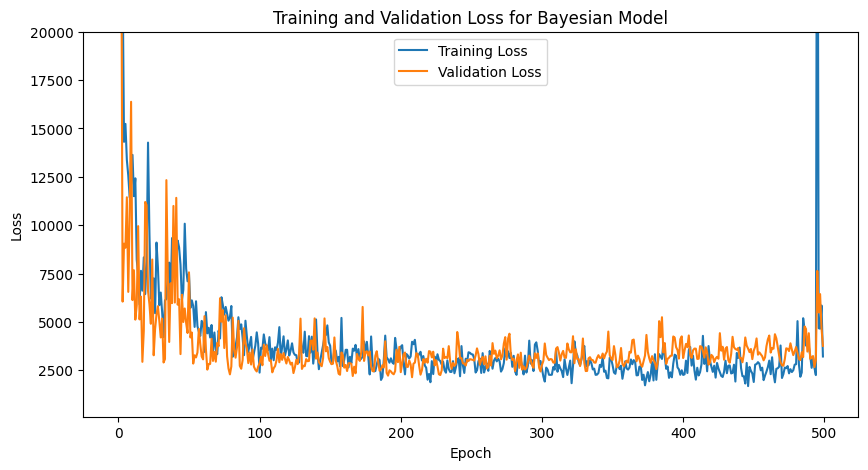

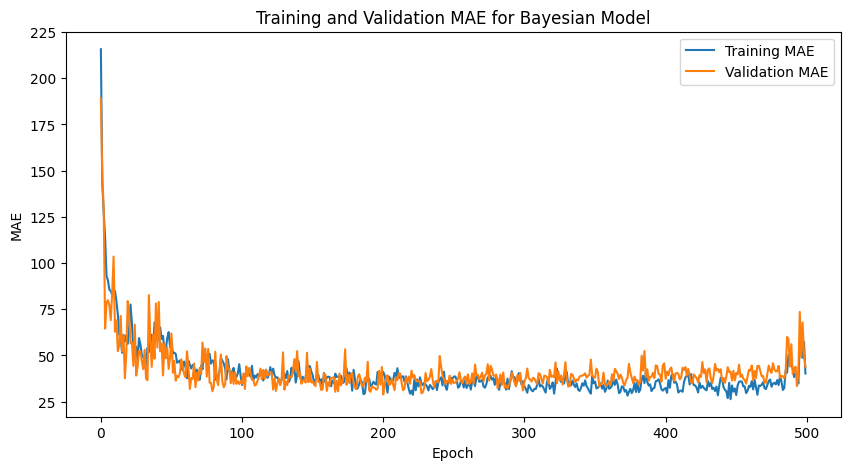

In [13]:
# 학습 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.ylim([100, 20000])  # Set the desired y value range
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Bayesian Model')
plt.legend()
plt.show()

# 학습 MAE와 검증 MAE 그래프
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['mae'], label='Training MAE')
plt.plot(history_best.history['val_mae'], label='Validation MAE')

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE for Bayesian Model')
plt.legend()
plt.show()


In [ ]:
#2회차
# 업데이트된 학습 데이터를 사용하여 새로운 BayesSearchCV 생성
bayes_search_updated1 = BayesSearchCV(
    keras_regressor,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=False
)

# Perform Bayesian Optimization with updated training data
bayes_search_updated1.fit(X_train_updated1, y_train_updated1)

# Print best hyperparameters from the updated search
print("Best hyperparameters after update:", bayes_search_updated1.best_params_)